#  MODEL : LJ13 at $T^*=0.4$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dataloader import load_dataset
from scripts import *
import numpy as np
from plotter import *
parula_map = get_parula_map()

In [2]:
num_particles = 13

# Convert coordinates to graphs. 

## Load Data 

We get our data from a monte carlo simulation of 13 self assembling atoms subject to the lennard jones potential $V(r) = \sum_{ij} \epsilon \left ( \frac{1}{r^{12}_{ij}} - \frac{1}{r^{6}_{ij}} \right)$. The particles are moving based on a stochastic process modelling brownian motion. We load the dataset consisting of 5001 atomic clusters and center them around the origin. We will denote this data with $\mathcal{X} \in \mathbb{R}^{13 \times 3}$. 

In [3]:
coordinates, potentials= load_dataset("../data/T04.txt", 13)
coordinates = center_dataset(coordinates)
total_samples = len(coordinates)
sample_size = total_samples
#sort dataset in increasing order of potentials (to visualize kernels)
u_idx = np.argsort(potentials)
coordinates_ = np.array([coordinates[i] for i in u_idx])
potentials_ = np.array([potentials[i] for i in u_idx])

## Visualizing the Dataset
Since it is impossible to visualize a 39 dimensional (13 particles $\times$ 3 coordinates) space, We plot all of the clusters in $\mathbb{R}^3$ space. Hence every point in $\mathcal{X}$ will have 13 points in $\mathbb{R^3}$, colored by the potential energy. We can observe a pattern based on the fact that the closer clusters are, the lower the energy and hence, we get a loose feel on the nature of our data in this manner. 

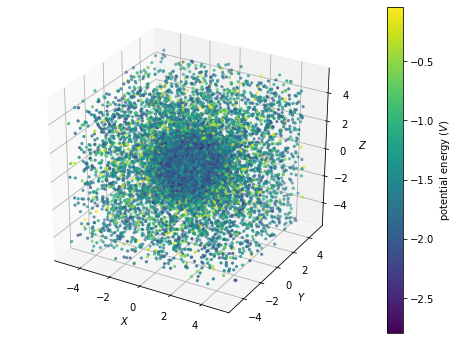

In [4]:
#collapse the dataset to 3d points dimensions
X = np.reshape(coordinates, [-1, 3])
# plot the dataset in 3d space and color with potential
#every point in coordinates have (num_particles) points in X colored by same energy value
fig1 = plt.figure(figsize=(8, 6))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
a = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.array(potentials).repeat(13), s=5)
plt.colorbar(a, label='potential energy ($V$)')
plt.savefig("statespace_04_non.png")

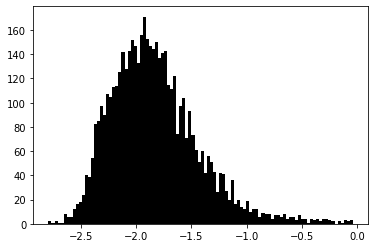

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.reshape(potentials, len(potentials)), bins=100, color='black')
plt.savefig("potentials04.png")

## Generating adjacency matrices

Our next step is to transform the coordinate space to a graphical representation defined via adjacency matrices. The 13 particles are mapped to each other based on a definition of bond. We define two matrices, namely R and G. R maps particles based on eucledian distance and G maps particles based on a binary value determined by a cutoff ($\rho$). 
$$
R_{ij} = ||x_i - x_j||  \\
$$
$$
G_{ij} = \begin{cases} 1 \mbox{,} & \mbox{if } R_{ij} \leq \rho \\ \mbox{0,} & \mbox{else} \end{cases}
$$
We set the cutoff distance as $\rho = 1.2 \sigma$ with $\sigma$ being the simulation unit. We define both R and G for all 5001 clusters in the dataset. This cutoff is determined based on the physics of the interaction potential. 

In [6]:
adjacency_matrices = [get_adjacent_matrices(config, 1.2) for config in coordinates_]
R = np.array(adjacency_matrices)[:, 0][:sample_size]
G = np.array(adjacency_matrices)[:, 1][:sample_size]
print(R.shape, G.shape)

(5001, 13, 13) (5001, 13, 13)


## Calculating graph laplacian matrices for adjacency matrices

Our next step is to calculate the laplacian matrices for $R$ and $G$. A laplacian matrix for an symmetric adjacency matrix $A$ is defined as
$$
L = D - A.
$$
Where, D is a diagonal matrix holding degrees (number of connections) of each particle in case of $G$. For $R$, $D$ will hold a continous form of the degrees. For our case, we interpret it as the surrounding surface area around a particle. We define two adjacency matrices for $R$ and $G$ namely, $L_R$ and $L_G$.

In [7]:
L_R = np.zeros(shape=R.shape)
L_G = np.zeros(shape=G.shape)
for i in range(sample_size):
    L_R[i] = np.diag(np.sum(R[i], axis=1)) - R[i]    #L_R = D_R - R
    L_G[i] = np.diag(np.sum(G[i], axis=1)) - G[i]    #L_G = D_G - G

## Eigendecomposition of laplacian matrices as a representation of the graphs

We define a spectral representation of atomic clusters calculated via eigen values and vectors of the graph laplacians  ( {$\Lambda_R$, $\Psi_R$} and {$\Lambda_G$, $\Psi_G$}). 

In [8]:
L_R_lmbd, L_R_psi = np.linalg.eig(L_R)
L_G_lmbd, L_G_psi = np.linalg.eig(L_G)

# Structural Variables calculation

In [27]:
#calculate structural variables
clusters = []
num_clusters = []
adjacency_matrices = []
spectral_radius = []
spectrum = []
vecs = []
for i, config in enumerate(coordinates[:sample_size]):
    eva, evc = np.linalg.eig(G[i])
    eva = sorted(np.abs(eva), reverse=True)
    spectral_radius.append(np.abs(eva[0] - eva[1]))
    spectrum.append(np.abs(eva))
    clusters.append(cluster_map(G[i]))
    num_clusters.append(len(clusters[len(clusters)-1]))

#connectivity values
connectivity = []
n_bonds = []
connectivity_r = []
for i in range(sample_size):
    connectivity.append(np.mean(np.sum(G[i], axis=1))/2.)
    n_bonds.append((np.trace(L_G[i])))
    connectivity_r.append(np.mean(np.sum(R[i], axis=1)))

#radius of gyration
rg = np.zeros(sample_size)
for i in range(sample_size):
    rg[i] = 0.5 * (1./num_particles) * np.trace(np.sqrt(L_R[i]))

#arrange structural vars based on increasing order of energy 
rg_ = np.zeros(shape=[len(rg)])
for i in range(len(u_idx)):
    rg_[u_idx[i]] = rg[i]

C:\Users\Aditya Dendukuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


# 1. Distance Kernel Calculation



In [10]:
def normalize(X):
    for i in range(len(X[:, 0])):
        X[:, i] = X[:, i]/np.linalg.norm(X[:, i])
    return X
'''
Cross correlation distance matrices
d_R_lmbd = eigenvalue distance for continous distance
d_G_lmbd = eigenvalue distance for binary distance
d_R_psi  = eigenvector distance for continous distance
d_G_psi  = eigenvector distance for binary distance
'''
d_R_lmbd = np.zeros(shape=[sample_size, sample_size])
d_G_lmbd = np.zeros(shape=[sample_size, sample_size])
d_R_psi  = np.zeros(shape=[sample_size, sample_size])
d_G_psi  = np.zeros(shape=[sample_size, sample_size])
for i in range(sample_size):
    idx_Ri = np.argsort(L_R_lmbd[i])
    idx_Gi = np.argsort(L_G_lmbd[i])
    for j in range(i, sample_size):
        idx_Gj = np.argsort(L_G_lmbd[j])
        idx_Rj = np.argsort(L_R_lmbd[j])
        #arrange eigenvalues in increasing order
        Rlmbd_i = L_R_lmbd[i][idx_Ri]
        Rlmbd_j = L_R_lmbd[j][idx_Rj]
        Glmbd_i = L_G_lmbd[i][idx_Gi]
        Glmbd_j = L_G_lmbd[j][idx_Gj]
        #rearranging eigenvectors based on sorted indices
        Rpsi_i = np.sort(abs(L_R_psi[i]).flatten())
        Rpsi_j = np.sort(abs(L_R_psi[j]).flatten())
        Gpsi_i = np.sort(abs(L_G_psi[i]).flatten())
        Gpsi_j = np.sort(abs(L_G_psi[j]).flatten())
        #distance calculation (L1 norm)
        N_inv = 1./num_particles
        d_R_lmbd[i][j] = N_inv*np.sum(abs(Rlmbd_i - Rlmbd_j))
        d_G_lmbd[i][j] = N_inv*np.sum(abs(Glmbd_i - Glmbd_j)) 
        d_R_lmbd[j][i] = d_R_lmbd[i][j]
        d_G_lmbd[j][i] = d_G_lmbd[i][j]
        #eigenvector distance 
        d_R_psi[i][j] = np.linalg.norm(Rpsi_i-Rpsi_j)
        d_G_psi[i][j] = np.linalg.norm(Gpsi_i-Gpsi_j)
        d_R_psi[j][i] = d_R_psi[i][j]
        d_G_psi[j][i] = d_G_psi[i][j]

### Choosing diffusion bandwidth $\epsilon$



In [11]:
def get_kernel_bandwidth(d):
    #selecting kernel bandwidth
    compute_A = lambda eps : np.sum(np.exp(-d**2/(2.*eps)))
    # Values of epsilon in base 2 we want to scan. 
    eps =np.exp(np.arange(-15.,15.,1))
    # Pre-allocate array containing sum(Aij). 
    Aij = np.zeros(eps.shape)
    # Loop through values of epsilon and evaluate matrix sum.
    for i in range(len(eps)): 
        A_ = compute_A(eps[i])
        Aij[i] = A_.sum()
    return np.log(eps), np.log(Aij)
#generate bandwidth samples for all the distance matrices
bwdth_Glmbd_x, bwdth_Glmbd_y = get_kernel_bandwidth(d_G_lmbd)
bwdth_Rlmbd_x, bwdth_Rlmbd_y = get_kernel_bandwidth(d_R_lmbd)
bwdth_Gpsi_x, bwdth_Gpsi_y   = get_kernel_bandwidth(d_G_psi)
bwdth_Rpsi_x, bwdth_Rpsi_y   = get_kernel_bandwidth(d_R_psi)

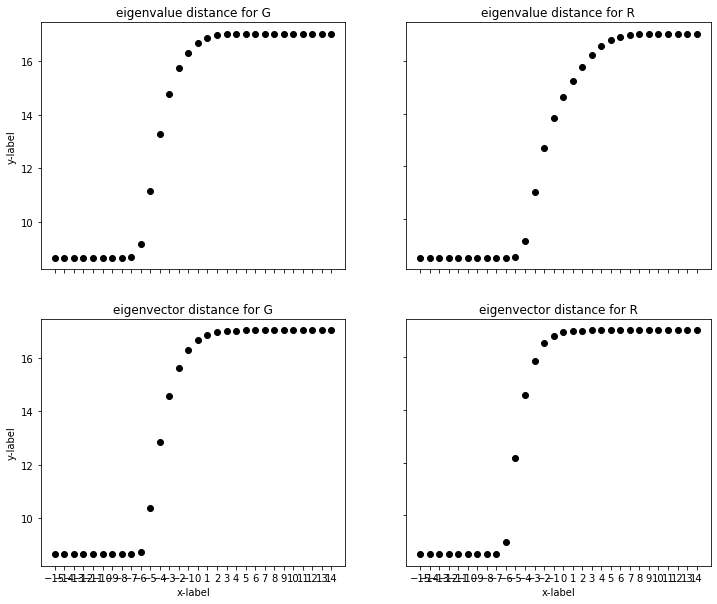

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(bwdth_Glmbd_x.real, bwdth_Glmbd_y.real, c='black')
axs[0, 0].set_title('eigenvalue distance for G')
axs[0, 1].scatter(bwdth_Rlmbd_x.real, bwdth_Rlmbd_y.real, c='black')
axs[0, 1].set_title('eigenvalue distance for R')
axs[1, 0].scatter(bwdth_Gpsi_x.real, bwdth_Gpsi_y.real, c='black')
axs[1, 0].set_title('eigenvector distance for G')
axs[1, 1].scatter(bwdth_Rpsi_x.real, bwdth_Rpsi_y.real, c='black')
axs[1, 1].set_title('eigenvector distance for R')
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
    ax.set_xticks(np.arange(-15.,15.,1))
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [13]:
Glmbd_eps = np.exp(1.)
Rlmbd_eps = np.exp(10.4)
Gpsi_eps  = np.exp(1.5)
Rpsi_eps  = np.exp(-1)

# Diffusion Maps algorithm

In [14]:
#calculate markov transition matrix 
K_Rlmbd = np.exp(-d_R_lmbd**2/(2.*Rlmbd_eps))
K_Glmbd = np.exp(-d_G_lmbd**2/(2.*Glmbd_eps))
K_Rpsi  = np.exp(-d_R_psi**2/(2.*Rpsi_eps))
K_Gpsi  = np.exp(-d_G_psi**2/(2.*Gpsi_eps))
#Normalize kernel to generate markov transition matrix (M)
M_Rlmbd = np.linalg.inv(np.diag(np.sum(K_Rlmbd, axis=1))) @ K_Rlmbd
M_Glmbd = np.linalg.inv(np.diag(np.sum(K_Glmbd, axis=1))) @ K_Glmbd
M_Rpsi  = np.linalg.inv(np.diag(np.sum(K_Rpsi , axis=1))) @ K_Rpsi 
M_Gpsi  = np.linalg.inv(np.diag(np.sum(K_Gpsi , axis=1))) @ K_Gpsi 
#calculate the eigenspace 
evals_Rlmbd, evecs_Rlmbd = np.linalg.eig(M_Rlmbd)
evals_Glmbd, evecs_Glmbd = np.linalg.eig(M_Glmbd)
evals_Rpsi , evecs_Rpsi  = np.linalg.eig(M_Rpsi )
evals_Gpsi , evecs_Gpsi  = np.linalg.eig(M_Gpsi )

In [15]:
evecs_Rlmbd = normalize(evecs_Rlmbd )
evecs_Glmbd = normalize(evecs_Glmbd )
evecs_Rpsi  = normalize(evecs_Rpsi  )
evecs_Gpsi  = normalize(evecs_Gpsi  )

C:\Users\Aditya Dendukuri\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


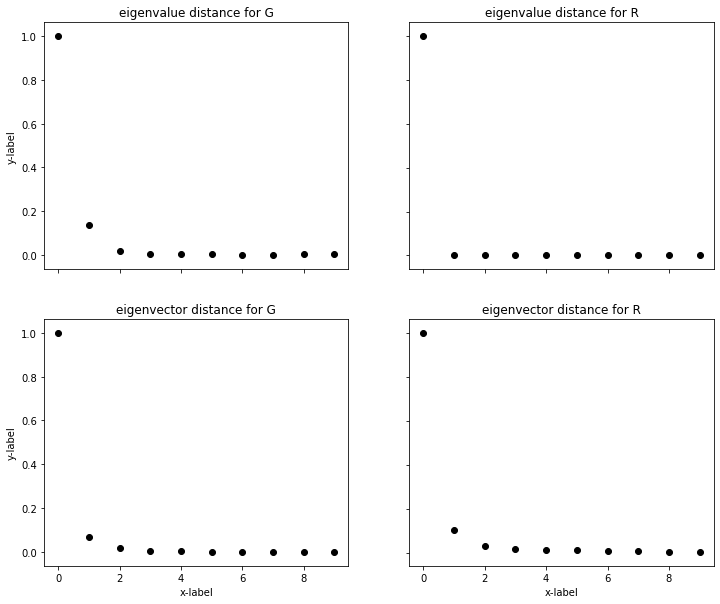

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
x = np.arange(0, 10)
axs[0, 0].scatter(x, evals_Glmbd[x], c='black')
axs[0, 0].set_title('eigenvalue distance for G')
axs[0, 1].scatter(x, evals_Rlmbd[x], c='black')
axs[0, 1].set_title('eigenvalue distance for R')
axs[1, 0].scatter(x, evals_Gpsi[x], c='black')
axs[1, 0].set_title('eigenvector distance for G')
axs[1, 1].scatter(x, evals_Rpsi[x], c='black')
axs[1, 1].set_title('eigenvector distance for R')
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [17]:
'''
Load subspaces by hausdorff and mayer results.
For code please contact Gulce Kalyoncu (gkalyoncu@uark.edu)
'''
import scipy.io as sio
mat = sio.loadmat('eigvecHDmayer_04.mat')
MAYER = mat['eps2_mayer']
HD = mat['eps1_HD']

C:\Users\Aditya Dendukuri\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


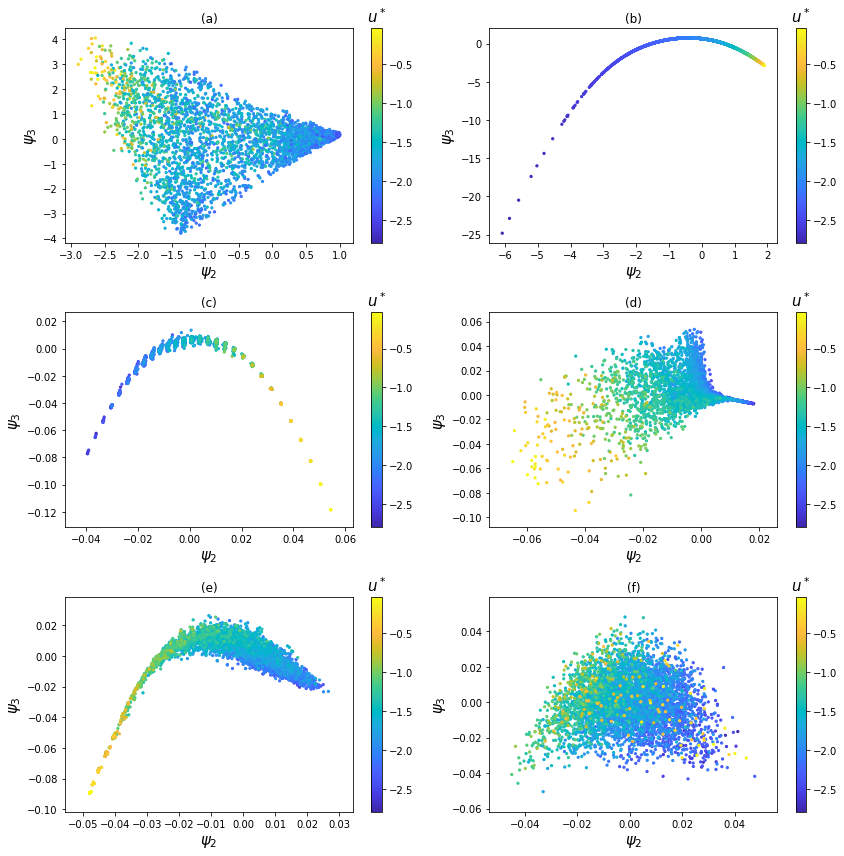

In [18]:

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.set_cmap('viridis')
a1=axs[0, 0].scatter(HD[:, 1], HD[:, 2],c= potentials[:sample_size] , s=5, cmap=parula_map)
axs[0, 0].set_title('(a)')
a2=axs[0, 1].scatter(MAYER[:,1], MAYER[:,2], c=potentials[:sample_size], s=5, cmap=parula_map)
axs[0, 1].set_title('(b)')
a3=axs[1, 0].scatter(evecs_Glmbd[:,1], evecs_Glmbd[:,2], c=potentials_[:sample_size], s=5, cmap=parula_map)
axs[1, 0].set_title('(c)')
a4=axs[1, 1].scatter(evecs_Rlmbd[:,1], evecs_Rlmbd[:,2], c=potentials_[:sample_size],s=5,cmap=parula_map)
axs[1, 1].set_title('(d)')
a5=axs[2, 0].scatter(evecs_Gpsi[:,1], evecs_Gpsi[:,2], c=potentials_[:sample_size], s=5, cmap=parula_map)
axs[2, 0].set_title('(e)')
a6=axs[2, 1].scatter(evecs_Rpsi[:,1], evecs_Rpsi[:,2], c=potentials_[:sample_size],s=5,cmap=parula_map)
axs[2, 1].set_title('(f)')
c1 = plt.colorbar(a1, ax=axs[0, 0])
c2 = plt.colorbar(a2, ax=axs[0, 1])
c3 = plt.colorbar(a3, ax=axs[1, 0])
c4 = plt.colorbar(a4, ax=axs[1, 1])
c5 = plt.colorbar(a5, ax=axs[2, 0])
c6 = plt.colorbar(a6, ax=axs[2, 1])
c1.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c2.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c3.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c4.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c5.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c6.ax.set_title('$u^*$', fontname='serif', fontsize=15)
for ax in axs.flat:
    ax.set_xlabel('$\psi_2$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\psi_3$', fontname='sans serif', fontsize=15)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.savefig("13p_t04_energylandscape.png")

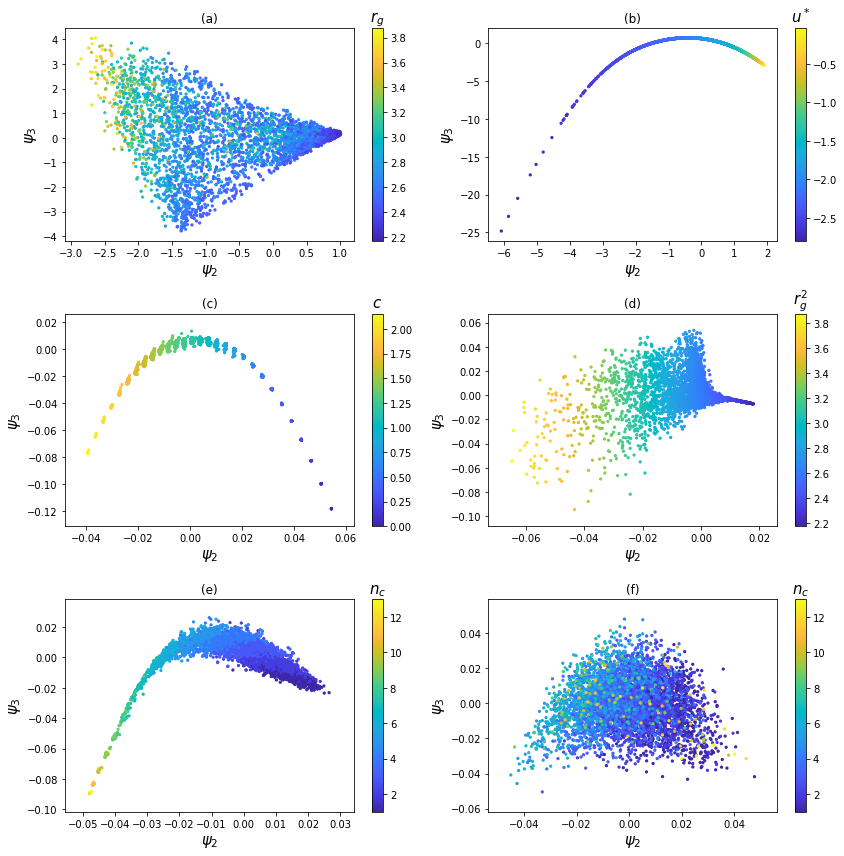

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.set_cmap('viridis')
a1=axs[0, 0].scatter(HD[:, 1], HD[:, 2],c= rg_[:sample_size] , s=5, cmap=parula_map)
axs[0, 0].set_title('(a)')
a2=axs[0, 1].scatter(MAYER[:,1], MAYER[:,2], c=potentials[:sample_size], s=5, cmap=parula_map)
axs[0, 1].set_title('(b)')
a3=axs[1, 0].scatter(evecs_Glmbd[:,1], evecs_Glmbd[:,2], c=connectivity[:sample_size], s=5, cmap=parula_map)
axs[1, 0].set_title('(c)')
a4=axs[1, 1].scatter(evecs_Rlmbd[:,1], evecs_Rlmbd[:,2], c=rg[:sample_size],s=5,cmap=parula_map)
axs[1, 1].set_title('(d)')
a5=axs[2, 0].scatter(evecs_Gpsi[:,1], evecs_Gpsi[:,2], c=num_clusters[:sample_size], s=5, cmap=parula_map)
axs[2, 0].set_title('(e)')
a6=axs[2, 1].scatter(evecs_Rpsi[:,1], evecs_Rpsi[:,2], c=num_clusters[:sample_size],s=5,cmap=parula_map)
axs[2, 1].set_title('(f)')
c1 = plt.colorbar(a1, ax=axs[0, 0])
c2 = plt.colorbar(a2, ax=axs[0, 1])
c3 = plt.colorbar(a3, ax=axs[1, 0])
c4 = plt.colorbar(a4, ax=axs[1, 1])
c5 = plt.colorbar(a5, ax=axs[2, 0])
c6 = plt.colorbar(a6, ax=axs[2, 1])
c1.ax.set_title('$r_g$', fontname='serif', fontsize=15)
c2.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c3.ax.set_title('$c$', fontname='serif', fontsize=15)
c4.ax.set_title('$r_g^2$', fontname='serif', fontsize=15)
c5.ax.set_title('$n_c$', fontname='serif', fontsize=15)
c6.ax.set_title('$n_c$', fontname='serif', fontsize=15)
for ax in axs.flat:
    ax.set_xlabel('$\psi_2$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\psi_3$', fontname='sans serif', fontsize=15)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.show()

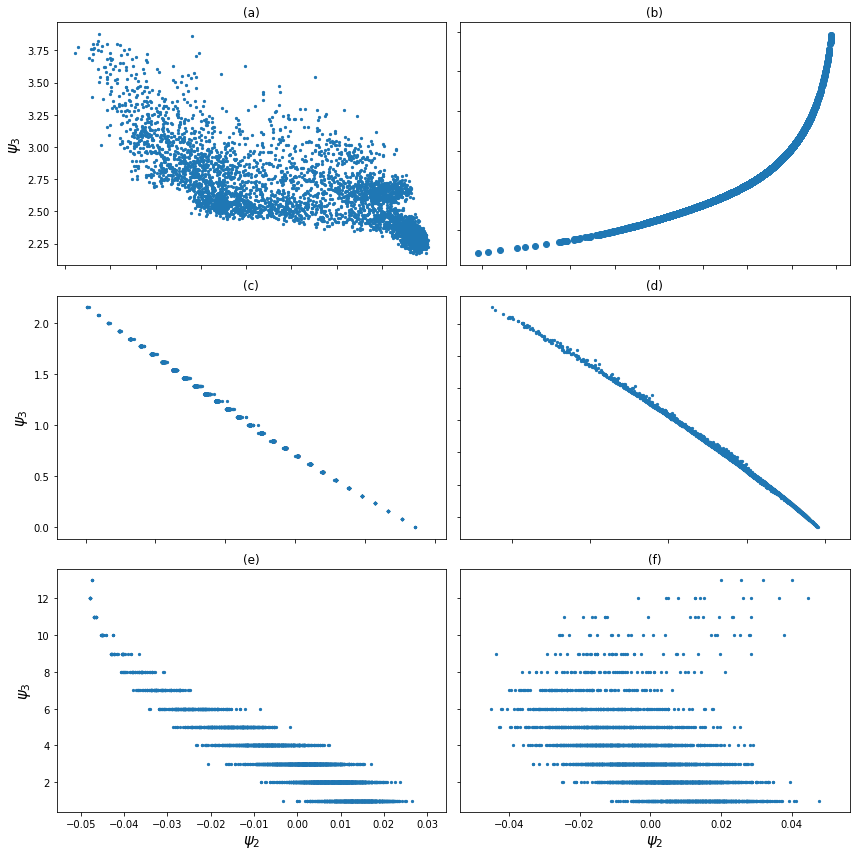

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.set_cmap('viridis')
a1=axs[0, 0].scatter(HD[:, 1], rg_, s=5, cmap=parula_map)
axs[0, 0].set_title('(a)')
a2=axs[0, 1].scatter(MAYER[:,1],potentials, cmap=parula_map)
axs[0, 1].set_title('(b)')
a3=axs[1, 0].scatter(evecs_Glmbd[:,1], connectivity, s=5, cmap=parula_map)
axs[1, 0].set_title('(c)')
a4=axs[1, 1].scatter(evecs_Rlmbd[:,1], rg,s=5,cmap=parula_map)
axs[1, 1].set_title('(d)')
a5=axs[2, 0].scatter(evecs_Gpsi[:,1],num_clusters[:sample_size], s=5, cmap=parula_map)
axs[2, 0].set_title('(e)')
a6=axs[2, 1].scatter(evecs_Rpsi[:,1], num_clusters[:sample_size],s=5,cmap=parula_map)
axs[2, 1].set_title('(f)')
for ax in axs.flat:
    ax.set_xlabel('$\psi_2$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\psi_3$', fontname='sans serif', fontsize=15)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.savefig("t04_13p_correlation_plots.png")